# Identifying neighbor-dependent genes from Slide-seq data in a mouse embryo

## Import packages

In [1]:
import pandas as pd
import requests
import os

In [2]:
import CellNeighborEX

print('Version:', CellNeighborEX.__version__)

Version: 1.0.1


## Download data
From spatial transcriptomics data with various formats including h5ad, we can obtain data regarding gene expression, cell type annotation (via additional analysis), and spatial coordinates. CellNeighborEX takes the data transformed to Pandas Dataframes as input. In this tutorial, we use the mouse embryo Slide-seq data. The dataset was obtained from Single Cell Portal (https://singlecell.broadinstitute.org/single_cell/study/SCP815/sensitive-spatial-genome-wide-expression-profiling-at-cellular-resolution#study-summary). We provide (i) pre-processed expression data in txt format, and (ii) data of annotated cell types and spatial coordinates in csv format.

In [3]:
# Check the path of your root directory.
os.getcwd()

'/Users/kimh15/test/docs/source/tutorials'

In [4]:
# Make a folder to save data files.
if not os.path.exists('Datasets'):
    os.makedirs('Datasets')

In [5]:
def download_file(url, file_path):
    response = requests.get(url)
    with open(file_path, 'wb') as file:
        file.write(response.content)

# Download pre-processed expression data
download_file("https://figshare.com/ndownloader/files/42333738", "Datasets/SSembryo_log_data.txt")
download_file("https://figshare.com/ndownloader/files/42333732", "Datasets/SSembryo_cell_id.txt")
download_file("https://figshare.com/ndownloader/files/42333735", "Datasets/SSembryo_gene_name.txt")

# Download data of annotated cell types and spatial coordinates
download_file("https://figshare.com/ndownloader/files/42333702", "Datasets/SSembryo_RCTD.csv")
download_file("https://figshare.com/ndownloader/files/42333711", "Datasets/SSembryo_abbrev.csv")

# The data can also be downloaded using the following method:
# # (i) pre-processed expression data
# !wget https://figshare.com/ndownloader/files/42333738 -O Datasets/SSembryo_log_data.txt
# !wget https://figshare.com/ndownloader/files/42333732 -O Datasets/SSembryo_cell_id.txt
# !wget https://figshare.com/ndownloader/files/42333735 -O Datasets/SSembryo_gene_name.txt

# # (ii) data of annotated cell types and spatial coordinates
# !wget https://figshare.com/ndownloader/files/42333702 -O Datasets/SSembryo_RCTD.csv
# !wget https://figshare.com/ndownloader/files/42333711 -O Datasets/SSembryo_abbrev.csv

## Load data
The 'SSembryo_RCTD.csv' file was generated from RCTD deconvolution results. In this file, 'first_type' and 'second_type' numerically represent the cell types specified in 'celltype1' and 'celltype2', respectively. When RCTD classifies a spot as a singlet, both 'cell type1' ('first_type') and 'cell type2' ('second_type') must be set to the same value, necessitating the duplication of 'first_type' into 'second_type'. Additionally, it is not necessary for the sum of 'prop1' and 'prop2' to equal 1, as the CellNeighborEX code includes a feature to normalize these proportions so that their total equals 1.

In [ ]:
# Set the path of data files regarding annotated cell types.
path = '/Users/kimh15/test/docs/source/tutorials/Datasets/'
df_processed = pd.read_csv(path + 'SSembryo_RCTD.csv', header=0)

# Add abbreviation of cell typs to df_processed.
df_abbrev = pd.read_csv(path + 'SSembryo_abbrev.csv', header=0)
for i in range(len(df_processed)):
    
    ct1 = df_processed['first_type'][i]
    ct2 = df_processed['second_type'][i]
    for j in range(len(df_abbrev)):
        
        if ct1 == df_abbrev['Cluster'][j]:
            df_processed['celltype1'][i] = df_abbrev['Abbrev'][j]
            
        if ct2 == df_abbrev['Cluster'][j]:
            df_processed['celltype2'][i] = df_abbrev['Abbrev'][j]

In [7]:
df_processed.head(5) # The spots are composed of one or two cell types. 

barcode  first_type  second_type celltype1 celltype2         x  \
0  TTTTTTTTTTTTTT          16           22        Sc       DEL    31.211   
1  GGTTTTTTTTTTTT          16           22        Sc       DEL  3738.900   
2  TTCAATTCTCGCTT          13           16        My        Sc  2113.100   
3  TTTCTGTGCAGACC          16           16        Sc        Sc  2112.900   
4  TTTCACAGCGACGT          13           16        My        Sc  1789.300   

        y     prop1     prop2  
0  5626.2  0.342930  0.136638  
1  3201.5  0.384132  0.126746  
2  5092.7  0.473911  0.363412  
3  4926.6  0.602552  0.000000  
4  4874.1  0.311685  0.411010

## Categorize Slide-seq beads into heterotypic spots and homotypic spots

### Generate data files categorized per cell type

In [ ]:
# All categorzied files (index_, matchComb_, neiCombUnique_, prop_ .csv) are saved in the "categorized_data folder" in the root directory.
CellNeighborEX.categorization.generate_input_files(data_type = "NGS", df = df_processed, sample_size=30, min_sample_size=1)

In [9]:
# Set the path of the directory where all the categorized data files are saved.
path_categorization = '/Users/kimh15/test/docs/source/tutorials/categorized_data/'  

### Get log-normalized expression data

In [10]:
# Save the data into dataframes.
df_cell_id = pd.read_csv(path + "SSembryo_cell_id.txt", delimiter="\t", header=None)
df_gene_name = pd.read_csv(path + "SSembryo_gene_name.txt", delimiter="\t", header=None)
df_log_data = pd.read_csv(path + "SSembryo_log_data.txt", delimiter=" ", header=None)

In [11]:
df_log_data.head(5)

0        1        2        3        4        5        6        7      \
0  2.38416  1.78334  1.37038  0.00000  1.42926  1.40604  0.00000  0.00000   
1  1.82691  1.78334  0.00000  0.00000  0.00000  0.00000  1.42685  1.46608   
2  1.82691  2.46166  1.37038  1.35354  1.99487  0.00000  0.00000  0.00000   
3  1.36022  1.24555  0.00000  0.00000  1.42926  0.00000  0.00000  0.00000   
4  1.00731  0.60155  0.00000  0.00000  0.00000  0.00000  0.00000  0.00000   

   8      9      ...  42352    42353  42354    42355  42356  42357  42358  \
0    0.0    0.0  ...    0.0  0.00000    0.0  3.52326    0.0    0.0    0.0   
1    0.0    0.0  ...    0.0  0.00000    0.0  0.00000    0.0    0.0    0.0   
2    0.0    0.0  ...    0.0  0.00000    0.0  0.00000    0.0    0.0    0.0   
3    0.0    0.0  ...    0.0  0.00000    0.0  0.00000    0.0    0.0    0.0   
4    0.0    0.0  ...    0.0  3.90762    0.0  0.00000    0.0    0.0    0.0   

   42359    42360  42361  
0    0.0  3.84741    0.0  
1    0.0  3.84741    0.0  
2    0.0  0.00000    0.0  
3    0.0  0.00000    0.0  
4    0.0  0.00000    0.0  

[5 rows x 42362 columns]

In [12]:
# The length of df_processed must be the same as the length of df_cell_id.
print(len(df_cell_id))
print(len(df_processed))

42362
42362


## Perform neighbor-dependent gene expression analysis

In [13]:
# Set argument values for CellNeighborEX.DEanalysis.analyze_data().
data_type = "NGS"  # Image: image-based ST data, NGS: NGS-based ST data
lrCutoff = 0.4 # log ratio 
pCutoff = 0.01 # p-value 
pCutoff2 = 0.01 # false discovery rate
direction = 'up' # up: up-reguated genes, down: down-regulated genes
normality_test = False # True: depending on the result of the normality test, the statistical test is determined. If the data is normal, the parametric test is used. Otherwise, the non-parametric test is used.
                       # False: when sample size (number of cells/spots) is larger than 30, the parameteric test is used. Otherwise, the non-parametric test is used.
top_genes = 10 # Top 10 DEGs are annotated in the volcano plot.


neighbor-dependent gene expression analysis:   0%|          | 0/72 [00:00<?, ?it/s]

0


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:   1%|▏         | 1/72 [00:06<07:35,  6.42s/it]

1


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:   3%|▎         | 2/72 [00:18<11:28,  9.84s/it]

2


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:   4%|▍         | 3/72 [00:24<09:27,  8.23s/it]

3


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:   6%|▌         | 4/72 [00:30<08:11,  7.23s/it]

4


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


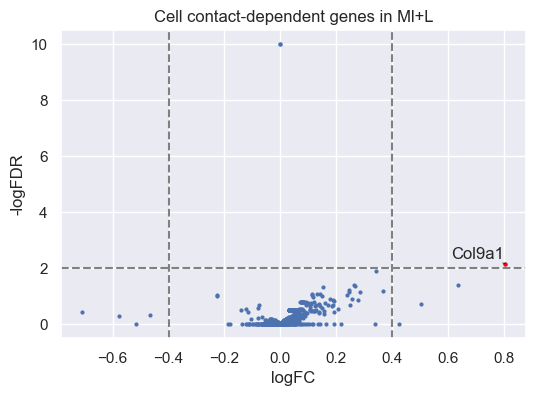

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


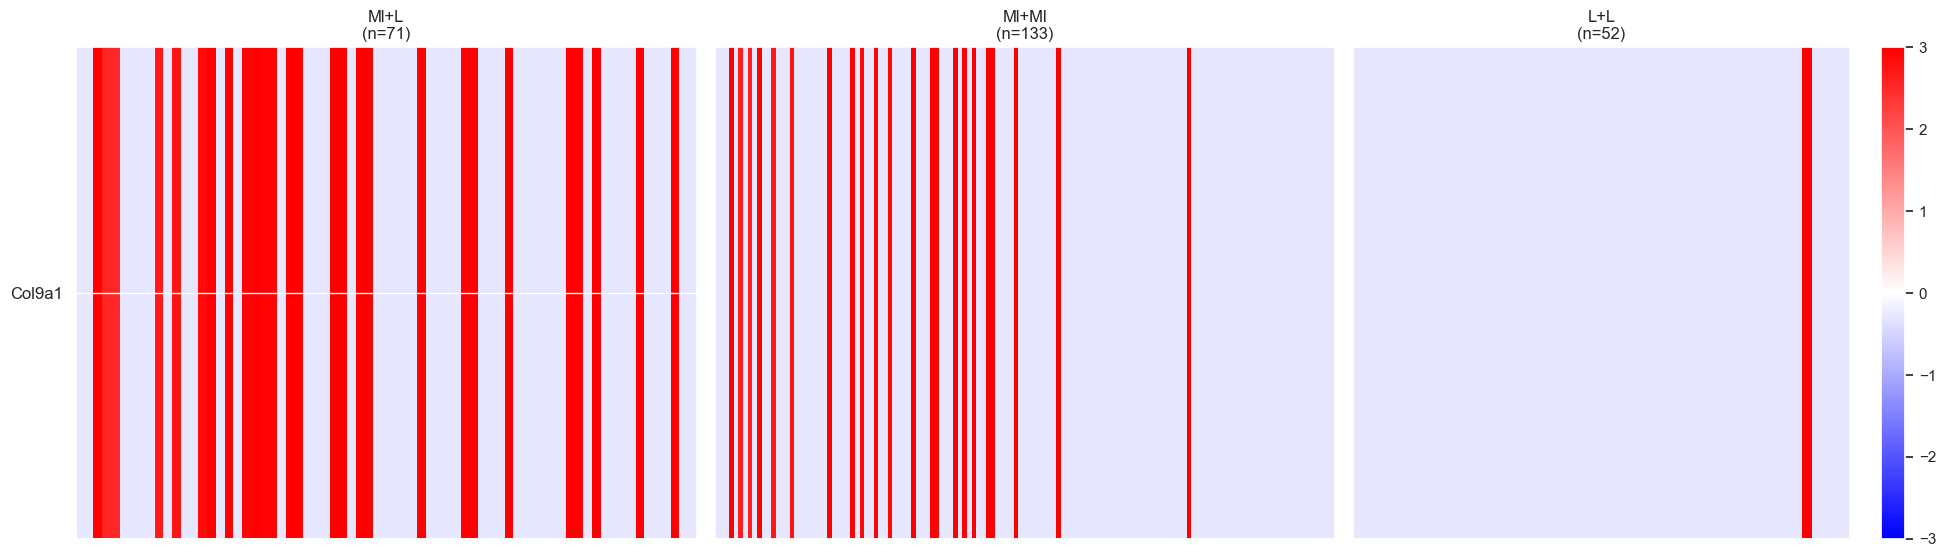

neighbor-dependent gene expression analysis:   7%|▋         | 5/72 [00:38<08:11,  7.33s/it]

5


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:   8%|▊         | 6/72 [00:44<07:40,  6.98s/it]

6


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  10%|▉         | 7/72 [00:50<07:03,  6.51s/it]

7


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  11%|█         | 8/72 [00:58<07:34,  7.11s/it]

8


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  12%|█▎        | 9/72 [01:01<06:14,  5.94s/it]

9


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  14%|█▍        | 10/72 [01:06<05:36,  5.42s/it]

10


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  15%|█▌        | 11/72 [01:12<05:47,  5.70s/it]

11


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  17%|█▋        | 12/72 [01:15<04:56,  4.93s/it]

12


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  18%|█▊        | 13/72 [01:18<04:21,  4.43s/it]

13


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  19%|█▉        | 14/72 [01:26<05:12,  5.39s/it]

14


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  21%|██        | 15/72 [01:32<05:19,  5.60s/it]

15


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  22%|██▏       | 16/72 [01:36<04:47,  5.13s/it]

16


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


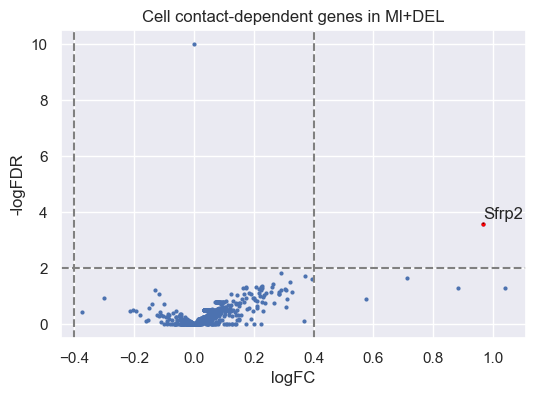

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


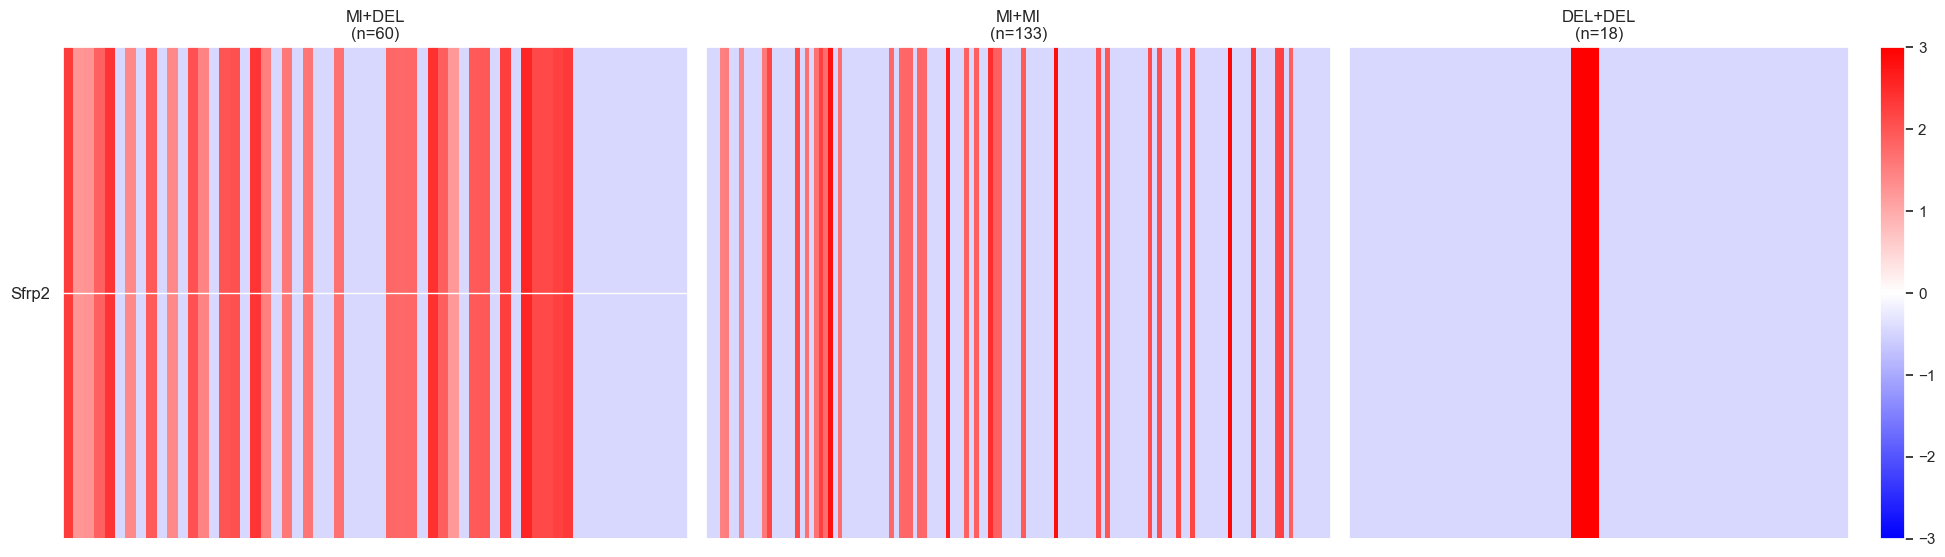

neighbor-dependent gene expression analysis:  24%|██▎       | 17/72 [01:44<05:21,  5.85s/it]

17


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  25%|██▌       | 18/72 [01:49<05:15,  5.84s/it]

18


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  26%|██▋       | 19/72 [01:53<04:26,  5.03s/it]

19


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  28%|██▊       | 20/72 [02:00<04:53,  5.64s/it]

20


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  29%|██▉       | 21/72 [02:06<05:00,  5.89s/it]

21


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  31%|███       | 22/72 [02:09<04:14,  5.09s/it]

22


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


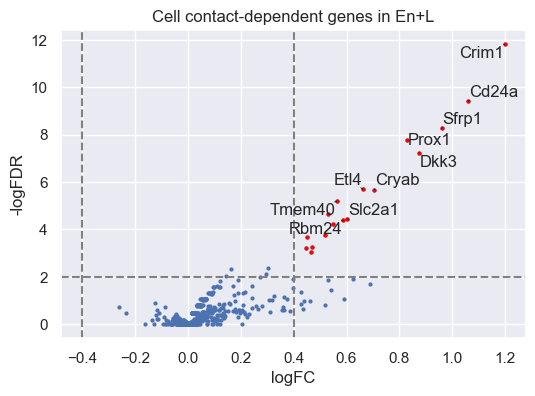

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


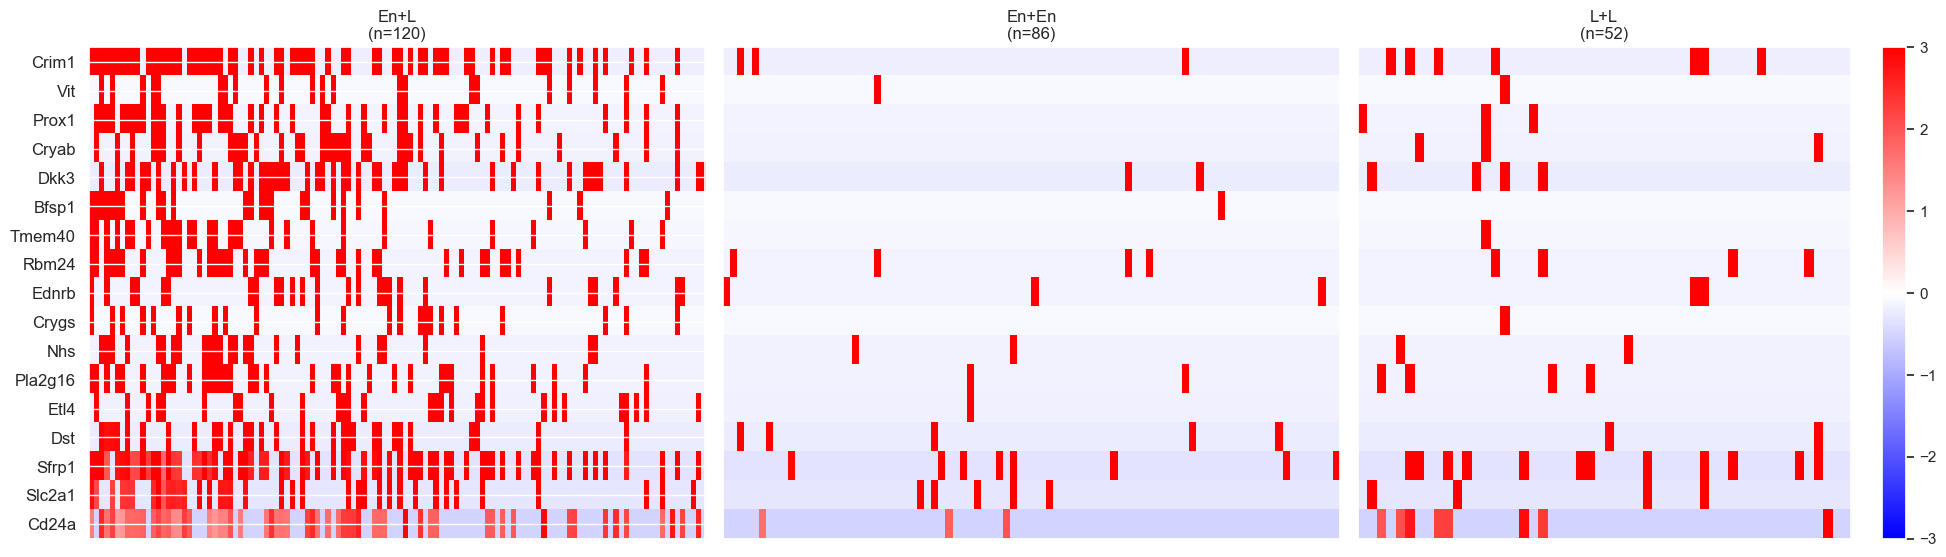

neighbor-dependent gene expression analysis:  32%|███▏      | 23/72 [02:17<04:46,  5.84s/it]

23


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  33%|███▎      | 24/72 [03:06<15:00, 18.76s/it]

24


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  35%|███▍      | 25/72 [03:14<12:12, 15.59s/it]

25


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


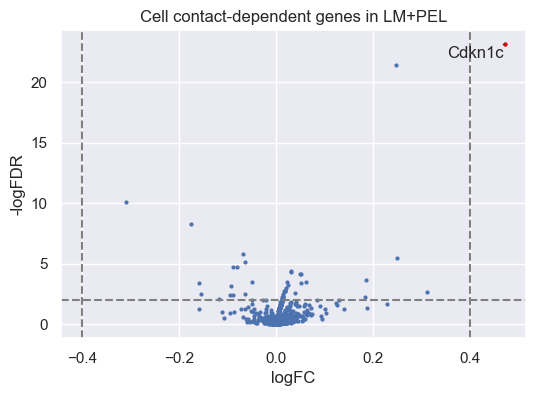

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


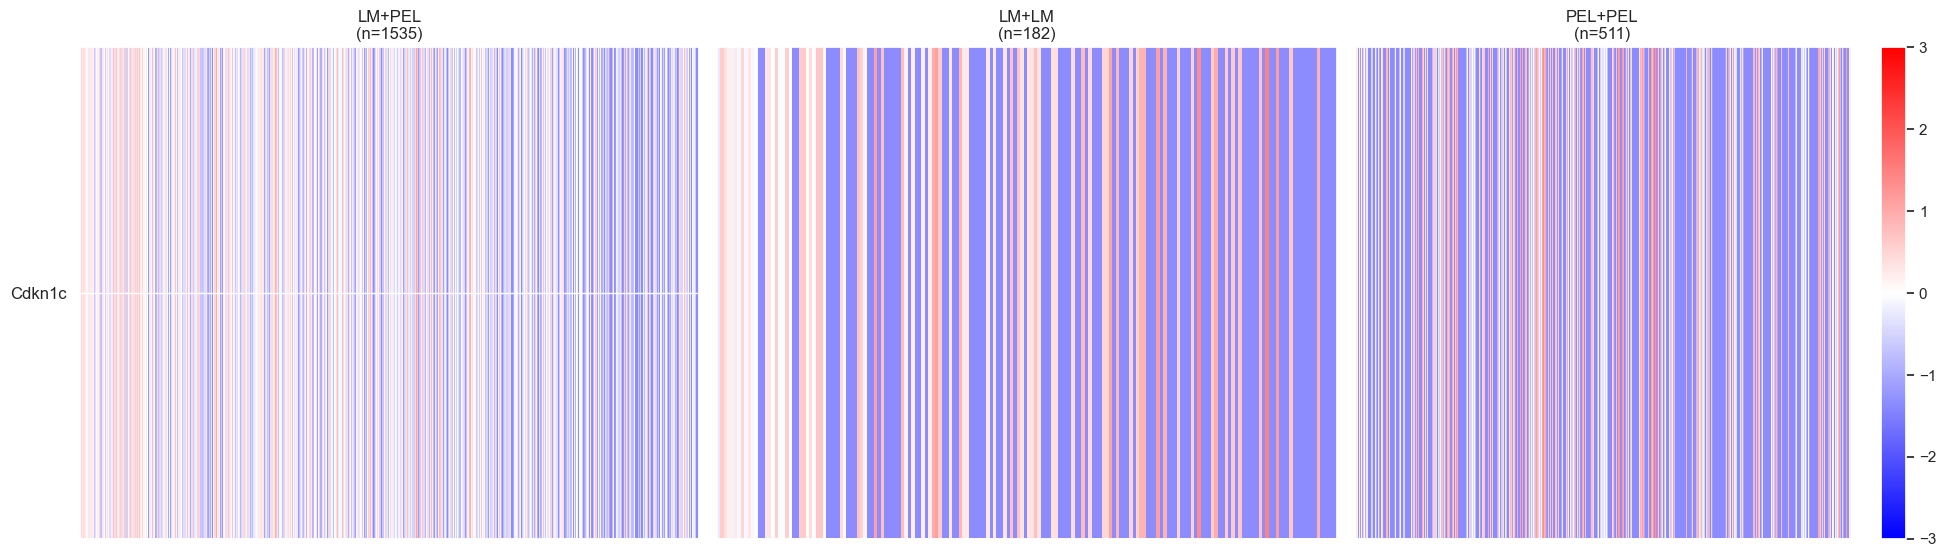

neighbor-dependent gene expression analysis:  36%|███▌      | 26/72 [03:26<11:07, 14.50s/it]

26


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  38%|███▊      | 27/72 [03:29<08:19, 11.11s/it]

27


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  39%|███▉      | 28/72 [03:32<06:21,  8.68s/it]

28


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  40%|████      | 29/72 [03:35<05:00,  7.00s/it]

29


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  42%|████▏     | 30/72 [03:45<05:24,  7.72s/it]

30


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  43%|████▎     | 31/72 [03:48<04:22,  6.39s/it]

31


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  44%|████▍     | 32/72 [03:51<03:41,  5.54s/it]

32


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  46%|████▌     | 33/72 [03:55<03:08,  4.82s/it]

33


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  47%|████▋     | 34/72 [04:01<03:18,  5.22s/it]

34


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  49%|████▊     | 35/72 [04:09<03:43,  6.03s/it]

35


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  50%|█████     | 36/72 [04:12<03:05,  5.15s/it]

36


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


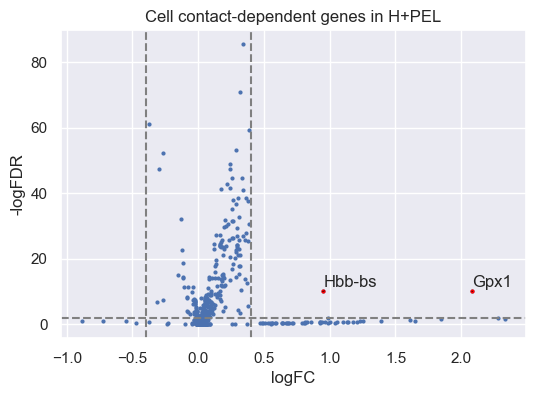

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


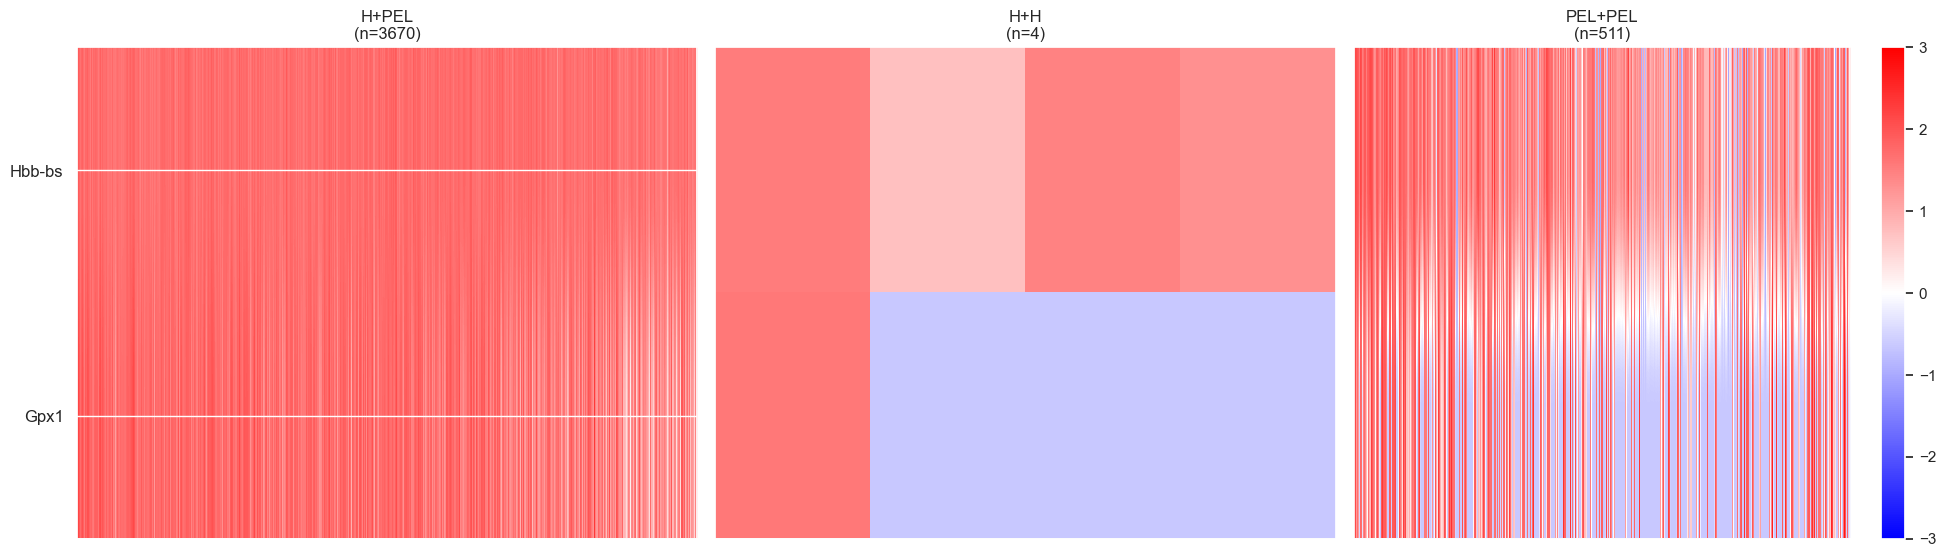

neighbor-dependent gene expression analysis:  51%|█████▏    | 37/72 [04:29<05:11,  8.91s/it]

37


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  53%|█████▎    | 38/72 [04:36<04:40,  8.25s/it]

38


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


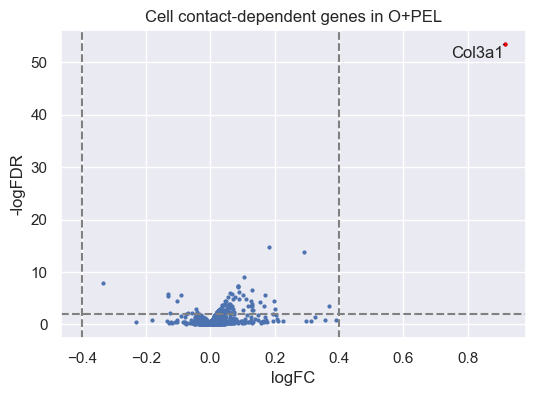

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


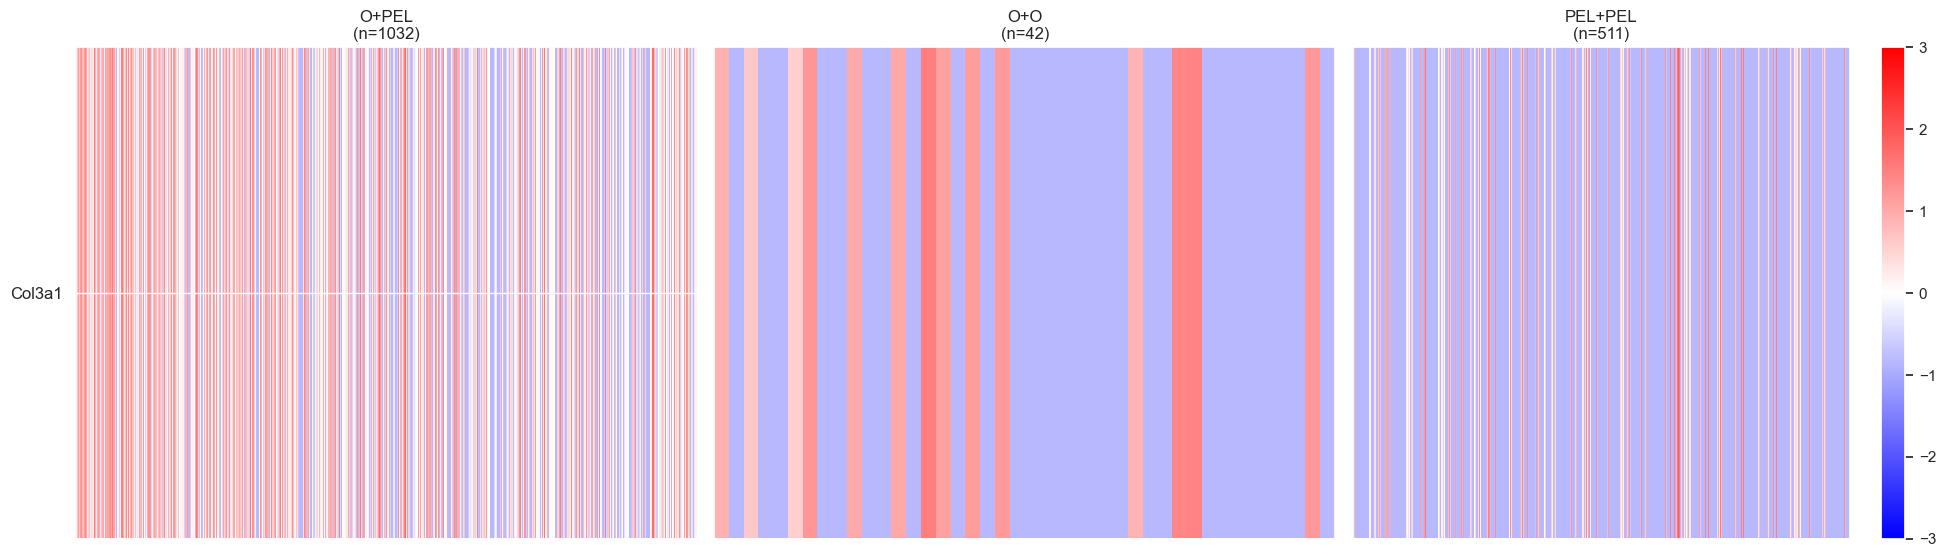

neighbor-dependent gene expression analysis:  54%|█████▍    | 39/72 [04:47<04:56,  8.99s/it]

39


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  56%|█████▌    | 40/72 [04:56<04:51,  9.12s/it]

40


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  57%|█████▋    | 41/72 [05:07<04:55,  9.53s/it]

41


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  58%|█████▊    | 42/72 [05:12<04:03,  8.12s/it]

42


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


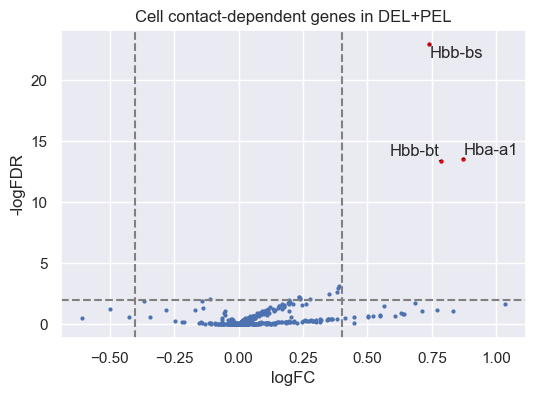

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


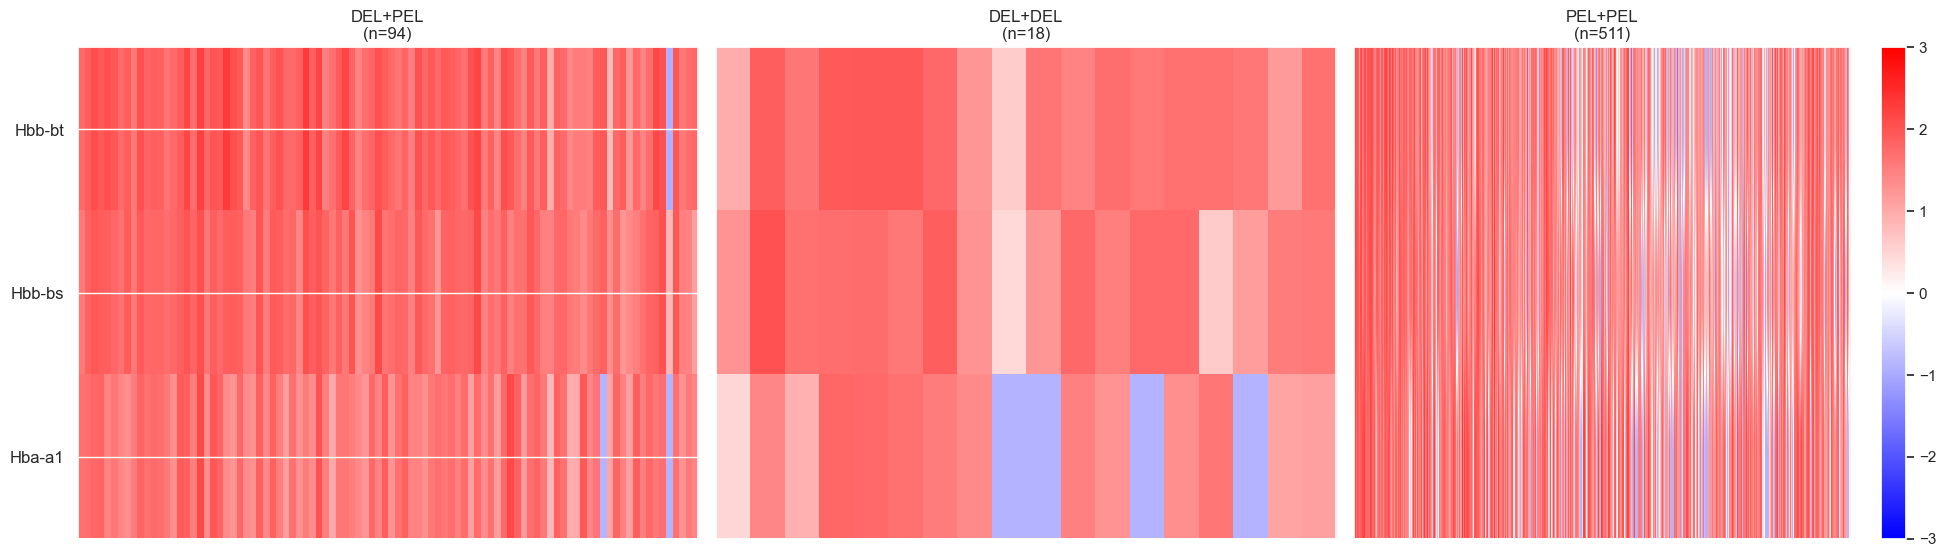

neighbor-dependent gene expression analysis:  60%|█████▉    | 43/72 [05:20<03:53,  8.05s/it]

43


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  61%|██████    | 44/72 [05:23<03:04,  6.59s/it]

44


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  62%|██████▎   | 45/72 [05:29<02:52,  6.38s/it]

45


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  64%|██████▍   | 46/72 [05:34<02:34,  5.94s/it]

46


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  65%|██████▌   | 47/72 [05:40<02:28,  5.96s/it]

47


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  67%|██████▋   | 48/72 [05:47<02:34,  6.45s/it]

48


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  68%|██████▊   | 49/72 [05:55<02:38,  6.88s/it]

49


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  69%|██████▉   | 50/72 [06:02<02:29,  6.79s/it]

50


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  71%|███████   | 51/72 [06:06<02:10,  6.20s/it]

51


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


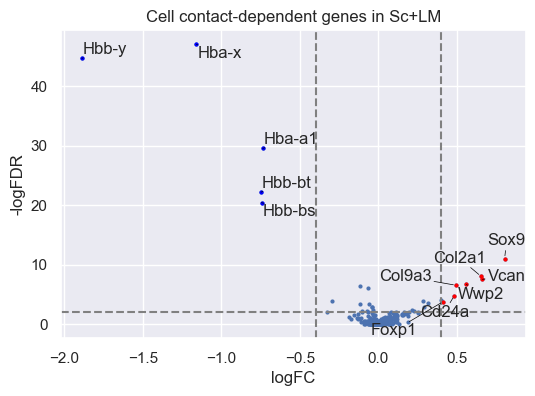

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


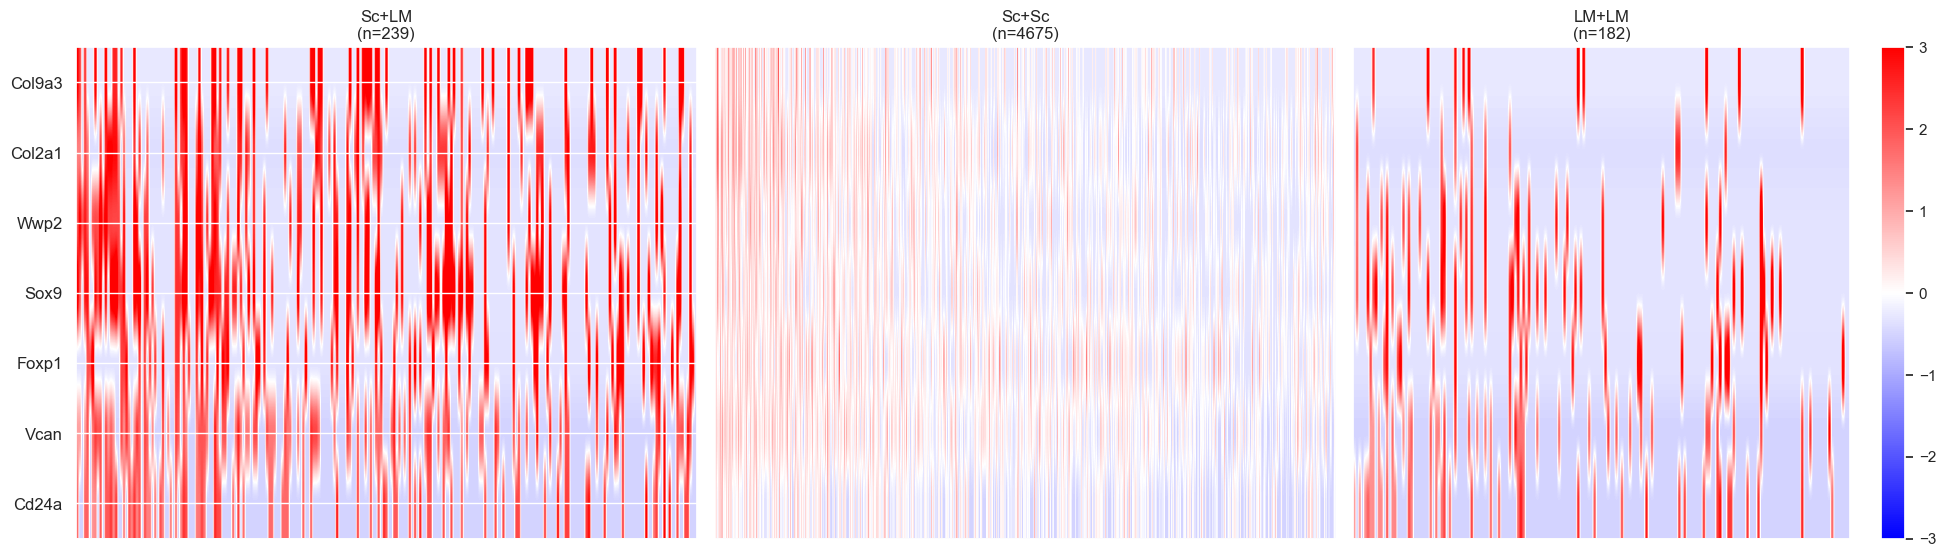

neighbor-dependent gene expression analysis:  72%|███████▏  | 52/72 [06:17<02:27,  7.38s/it]

52


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  74%|███████▎  | 53/72 [06:20<01:57,  6.16s/it]

53


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  75%|███████▌  | 54/72 [06:26<01:51,  6.20s/it]

54


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  76%|███████▋  | 55/72 [06:29<01:29,  5.28s/it]

55


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]


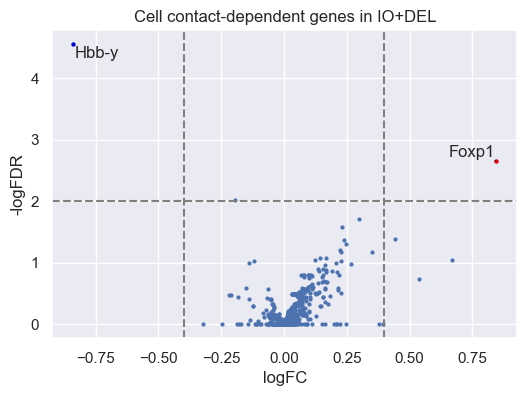

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


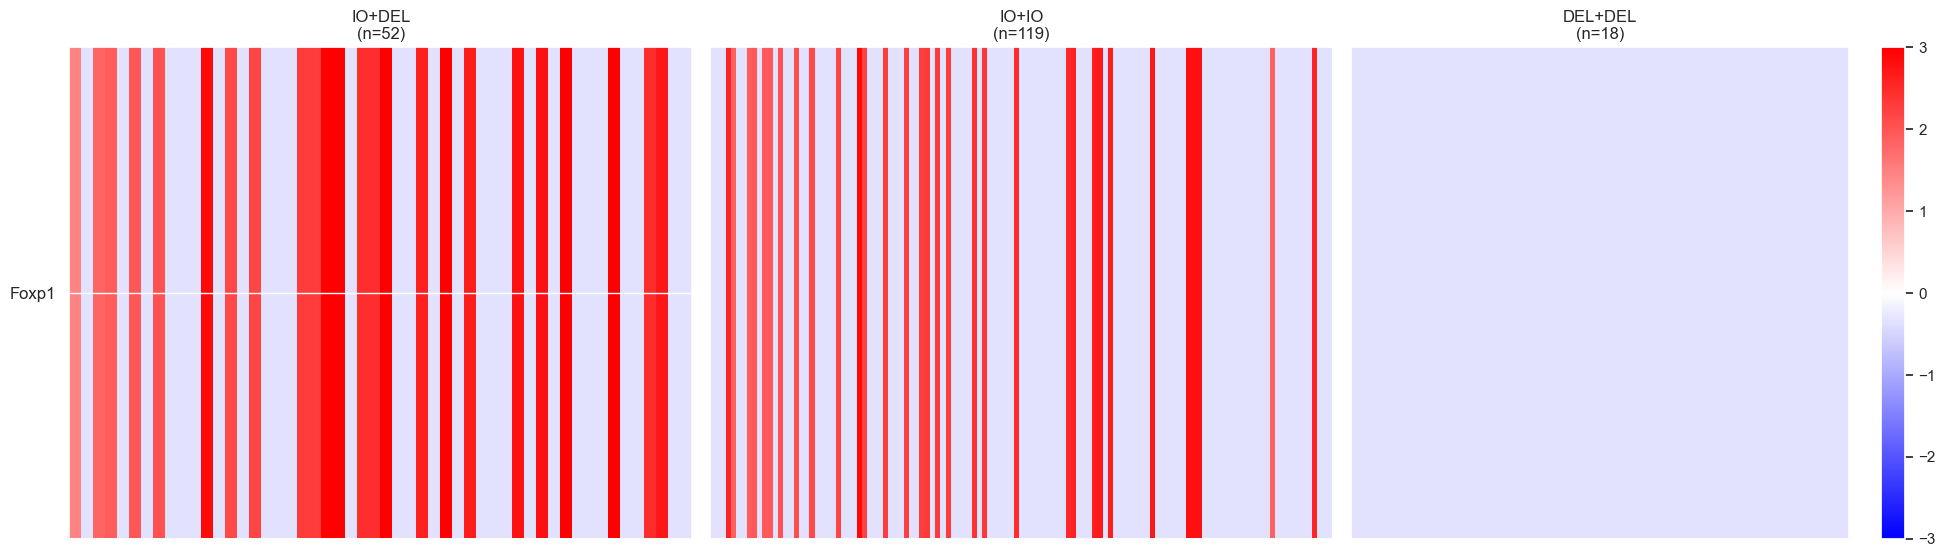

neighbor-dependent gene expression analysis:  78%|███████▊  | 56/72 [06:37<01:34,  5.89s/it]

56


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  79%|███████▉  | 57/72 [06:44<01:33,  6.26s/it]

57


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  81%|████████  | 58/72 [06:47<01:16,  5.46s/it]

58


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  82%|████████▏ | 59/72 [06:53<01:11,  5.53s/it]

59


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  83%|████████▎ | 60/72 [06:57<00:59,  4.96s/it]

60


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


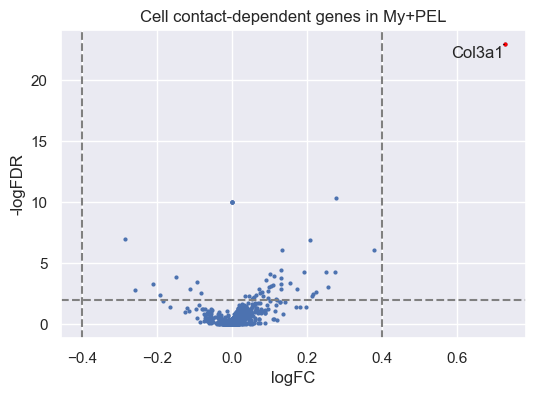

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


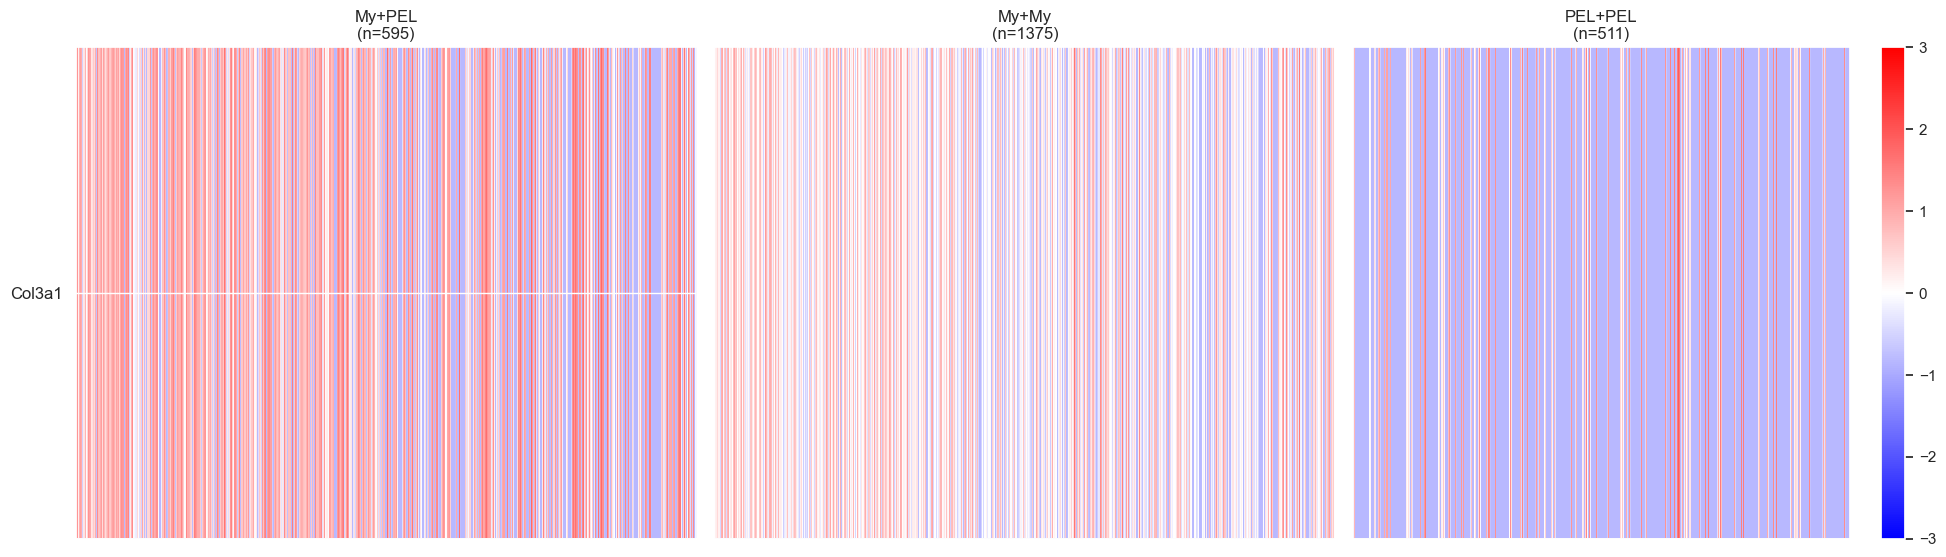

neighbor-dependent gene expression analysis:  85%|████████▍ | 61/72 [07:07<01:11,  6.49s/it]

61


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  86%|████████▌ | 62/72 [07:11<00:58,  5.87s/it]

62


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  88%|████████▊ | 63/72 [07:16<00:50,  5.56s/it]

63


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  89%|████████▉ | 64/72 [07:20<00:40,  5.04s/it]

64


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  90%|█████████ | 65/72 [07:27<00:39,  5.65s/it]

65


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  92%|█████████▏| 66/72 [07:36<00:39,  6.64s/it]

66


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


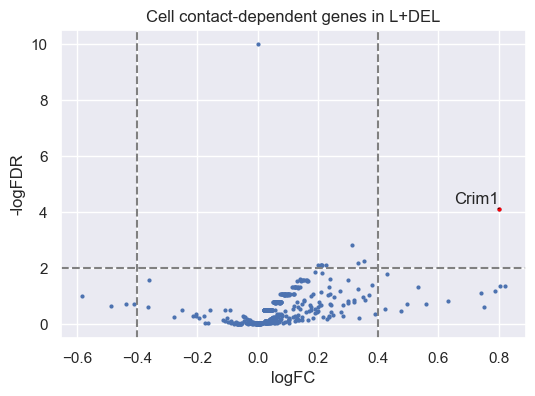

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


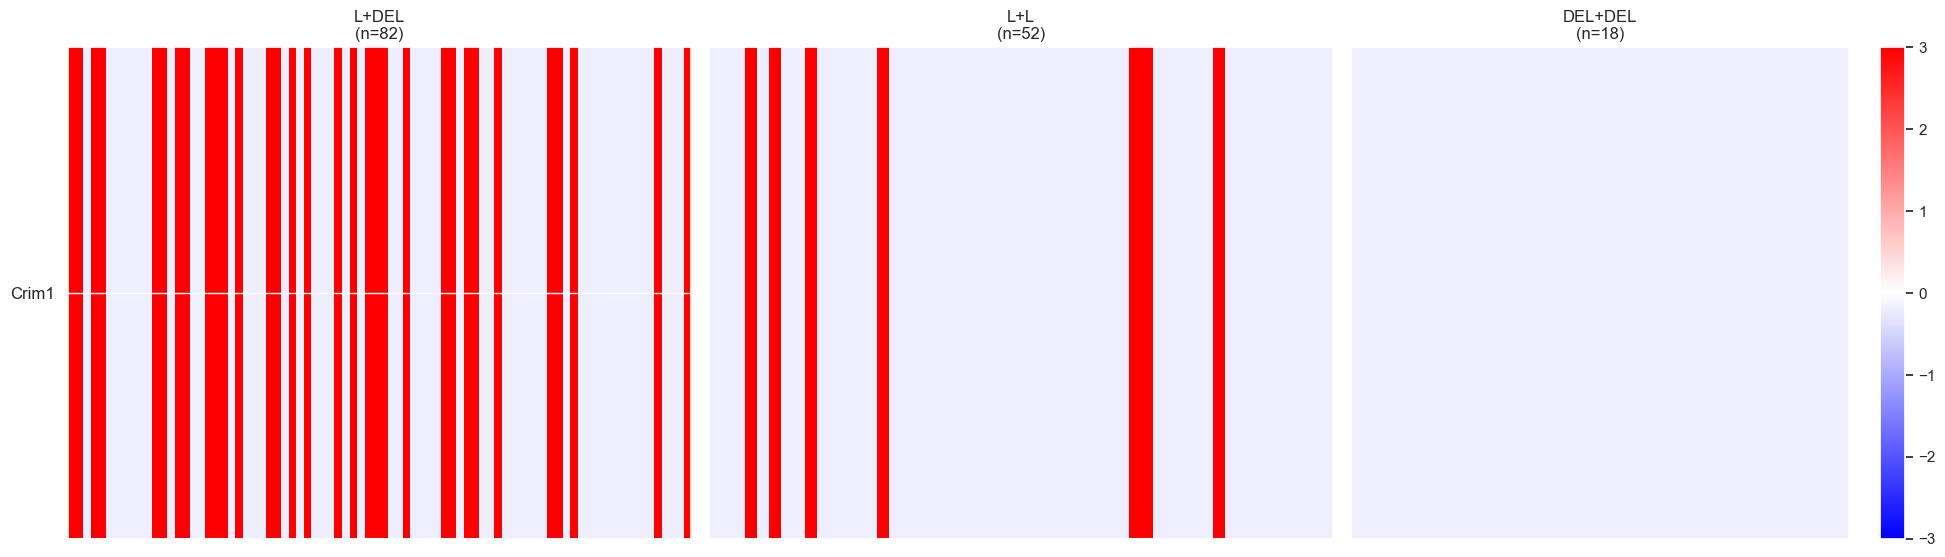

neighbor-dependent gene expression analysis:  93%|█████████▎| 67/72 [07:44<00:35,  7.01s/it]

67


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:939: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['largest_pvalue'][i] = 0.0000000001


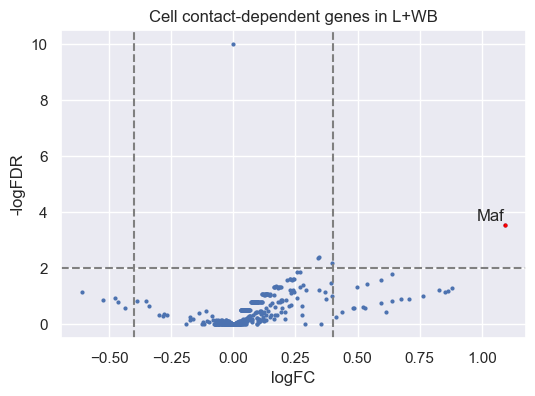

/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:672: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(a, fontsize=12)  # Sets the y-axis tick labels with fontsize 12


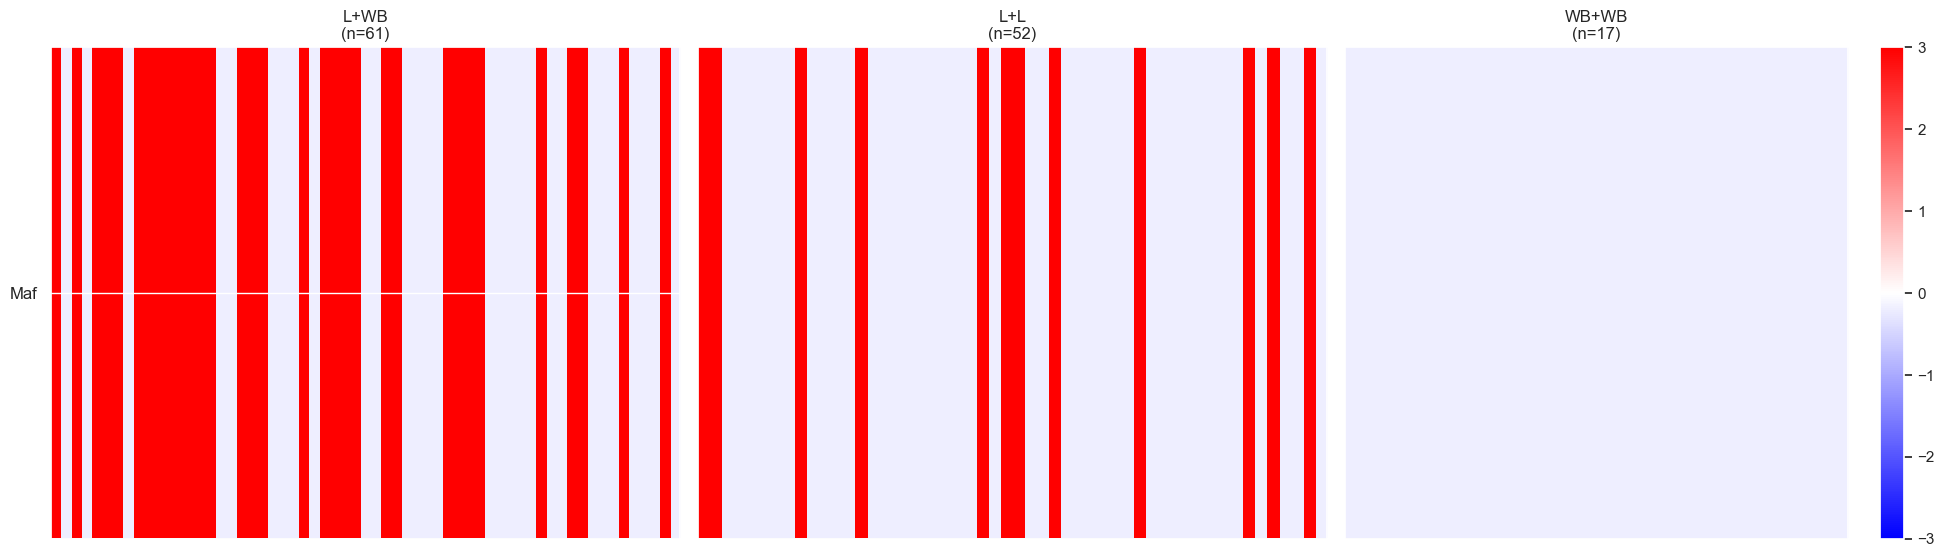

neighbor-dependent gene expression analysis:  94%|█████████▍| 68/72 [07:51<00:28,  7.13s/it]

68


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  96%|█████████▌| 69/72 [07:55<00:18,  6.04s/it]

69


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  97%|█████████▋| 70/72 [07:58<00:10,  5.31s/it]

70


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis:  99%|█████████▊| 71/72 [08:02<00:04,  4.72s/it]

71


/opt/anaconda3/envs/CellNeighborEX-env/lib/python3.10/site-packages/CellNeighborEX/DEanalysis.py:1145: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  log_data_zvalue = (log_data_total - mean_values[:, np.newaxis]) / std_values[:, np.newaxis]
neighbor-dependent gene expression analysis: 100%|██████████| 72/72 [08:07<00:00,  6.77s/it]


In [14]:
# If save=True, all result files (DEG list: csv, heatmaps and volcano plots: pdf, gene expression values: txt) are saved in the "DE_results" folder in the root directory.
DEG_list = CellNeighborEX.DEanalysis.analyze_data(df_cell_id, df_gene_name, df_log_data, path_categorization, data_type, lrCutoff, pCutoff, pCutoff2, direction, normality_test, top_genes, save=True)

## Visualize neighbor-dependent gene expression in the spatial context

In [15]:
# Select a cell type and a DEG for spatial visualization and then load the data.
# For example, Cd24a is one of up-regulated genes identified from the heterotypic spots of En+L.
path_selected = '/Users/kimh15/test/docs/source/tutorials/DE_results/En+L/'
column_names = ['barcode', 'logdata', 'zscore']
heterotypic = pd.read_csv(path_selected + "En+L_Cd24a.txt", delimiter=",", names = column_names)
homotypic1 = pd.read_csv(path_selected + "En+En_Cd24a.txt", delimiter=",", names = column_names)
homotypic2 = pd.read_csv(path_selected + "L+L_Cd24a.txt", delimiter=",", names = column_names)
heterotypic['type'] = 'En+L'
homotypic1['type'] = 'En+En'
homotypic2['type'] = 'L+L'
df_exp = pd.concat([heterotypic, homotypic1, homotypic2])

In [ ]:
# Set parameter values.
df_bg, df_red, df_blue, df_black = CellNeighborEX.visualization.set_parameters(df_processed, df_exp, beadsize_bg=10, edgecolor_bg=(0.85,0.85,0.85), beadcolor_bg=(0.85,0.85,0.85), beadsize_red=600, beadsize_blue=200, beadsize_black=200, type_red='En+L', type_blue='En+En', type_black='L+L') 

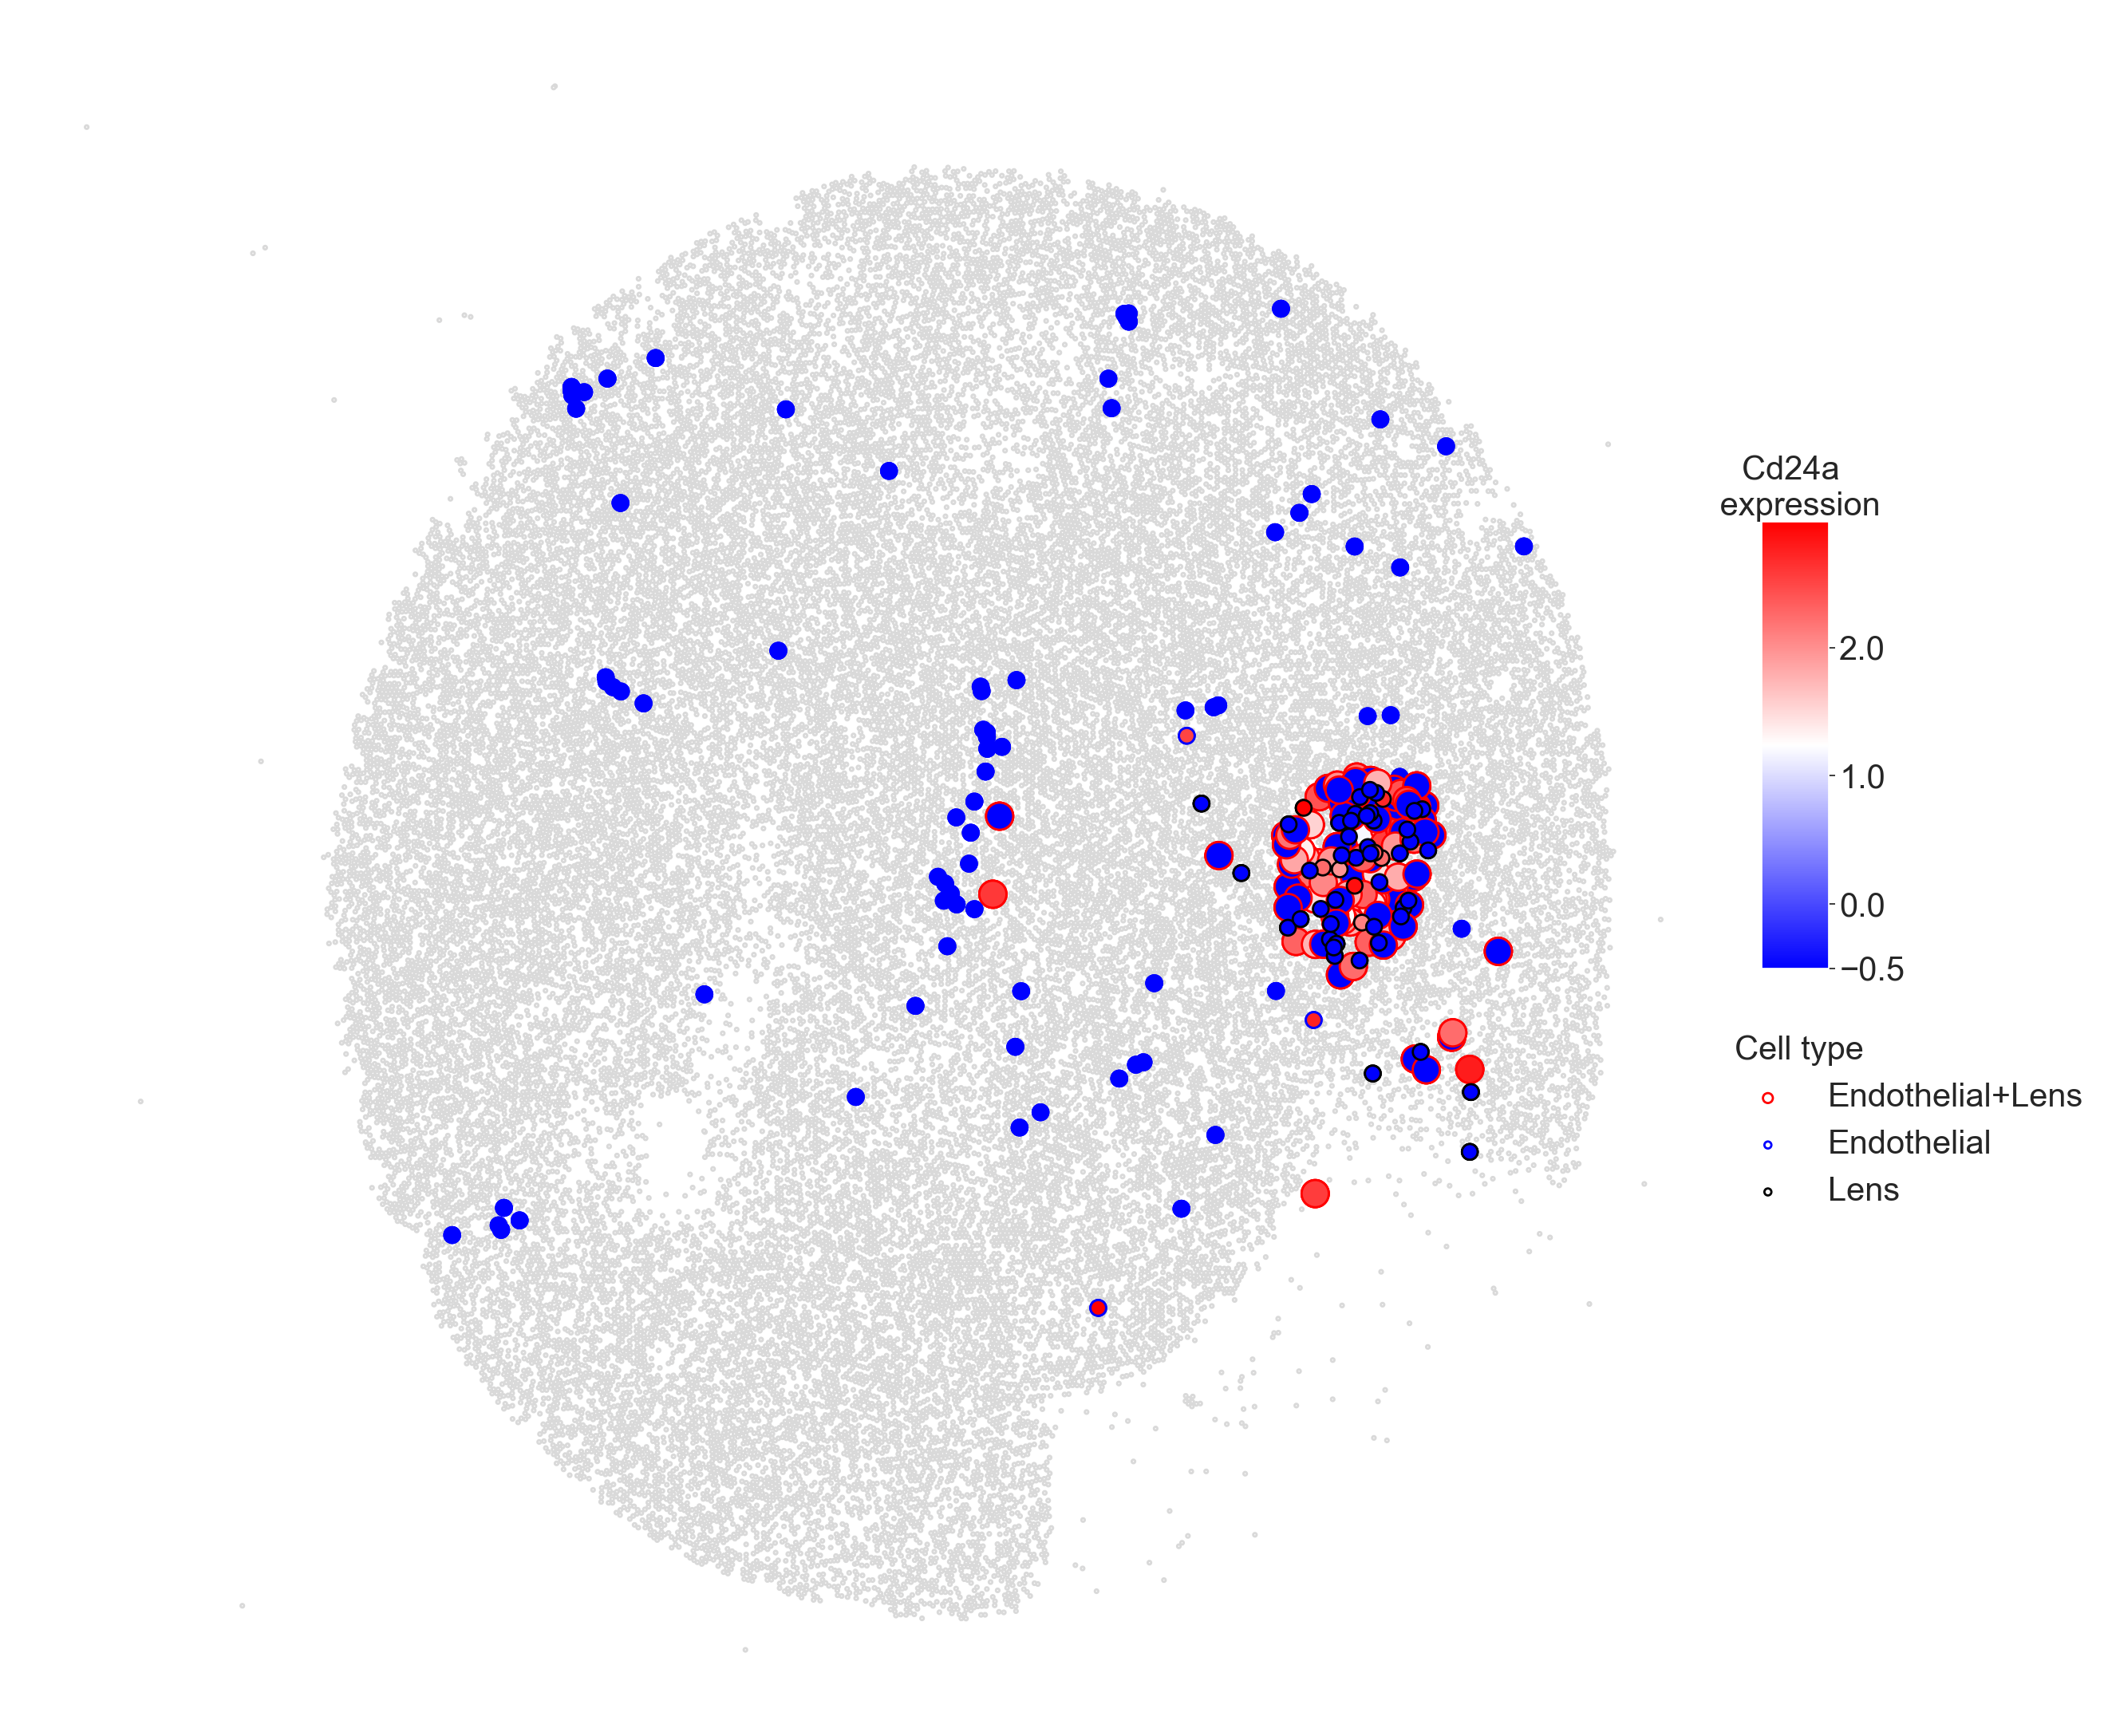

In [17]:
# Get the spatial map.
# zorder_red, zorder_blue, and zorder_black are parameters that determine the drawing order in the spatial map.
# If save=True, the spatial map (Cd24a.pdf) is saved in the "spatialMap" folder in the root directory.
CellNeighborEX.visualization.get_spatialPlot(df_bg, df_red, df_blue, df_black, label_red='Endothelial+Lens', label_blue='Endothelial', label_black='Lens', label_gene='Cd24a', zorder_red=3.0, zorder_blue=2.0, zorder_black=4.0,figsize=(28,28), save=True)

FYI, the output files generated by CellNeighborEX in this tutorial can be downloaded at https://figshare.com/ndownloader/files/42352761.